In [2]:
import general_tools

ImportError: No module named general_tools

In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 2
setup_one_gpu(GPU)

ImportError: No module named general_tools.notebook.gpu_utils

In [1]:
import sys
sys.path.append('/Users/ruqihuang/my-venv')

In [2]:
import numpy as np
import tensorflow as tf
import os.path as osp
import matplotlib.pylab as plt
from collections import defaultdict
import time

/Users/ruqihuang/my-venv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from general_tools.notebook.tf import reset_tf_graph
#from geo_tool import Point_Cloud, Mesh
#from geo_tool.solids.plotting import plot_mesh_via_matplotlib as plot_mesh

In [4]:
import tf_lab.diff_maps.helper as helper

from tf_lab.diff_maps.in_out import raw_data, produce_net_data,\
prep_splits_labels_for_task, produce_diff_maps, classes_of_tasks, load_latent_diff

from tf_lab.diff_maps.basic_nets import pc_net, diff_mlp_net, diff_conv_net, pc_versions
from tf_lab.diff_maps.basic_nets import Basic_Net

Instructions for updating:
Use the retry module or similar alternatives.


In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
def average_l2_distance(gt_vecs, pred_vecs):
    return np.mean(np.sqrt(np.sum(np.square((gt_vecs - pred_vecs)), axis=1)))

def average_mse(gt_vecs, pred_vecs):
    return np.mean(np.sum(np.square((gt_vecs - pred_vecs))))

def score_net(task, stats):
    train_s = np.array(stats['train'])
    test_s = np.array(stats['test'])
    val_s = np.array(stats['val'])

    if task == 'regression':
        seek = np.min(val_s)
    else:
        seek = np.max(val_s)

    val_best_all = np.where(val_s == seek)[0]
    val_maximizer = val_best_all[0]
    test_best = test_s[val_maximizer]
    train_best = train_s[val_maximizer]
    gen_error = test_best - train_best   
    return len(val_best_all), val_maximizer, gen_error[0], test_best[0]

In [7]:
total_shapes = helper.total_shapes
n_pose_classes = helper.n_pose_classes
seeds = [42, 100, 666, 1821, 2004]

top_mesh_dir = '/Users/ruqihuang/my-venv/DATA/Meshes/SCAPE_8_poses/'
gt_param_f = osp.join(top_mesh_dir, 'gt_shape_params.mat')
top_data_dir = '/Users/ruqihuang/my-venv/DATA/OUT/latent_diff_maps/experiments/SCAPE_8_poses'

In [68]:
n_cons = 40
use_pc = False
knn = 0
arch = 'conv'
sub_member_per_class = 50
n_shapes = sub_member_per_class * n_pose_classes
val_per = 0.10
test_per = 0.15
train_per = 1.0 - (val_per + test_per)
n_pc_points = 1024
task = 'regression'
# task = 'pose_clf'
mean_norm_diffs = True
synced_bases_file = osp.join(top_data_dir, '50_extract_%d_knn_50_fmapd.mat' % (knn,) )
# synced_bases_file = osp.join(top_data_dir, 'sparse_computed1.mat' )
# latent_diff_file = osp.join(top_data_dir, 'latent_diff_comp.mat')

In [69]:
if use_pc:
    learning_rate = 0.005
    batch_size = 50
    pc_version = 'v2'
else:
    learning_rate = 0.007
    batch_size = 50

In [70]:
from tf_lab.diff_maps.helper import load_gt_latent_params, sub_collection_pose_labels

In [71]:
gt_latent_params = load_gt_latent_params(gt_param_f, sub_member_per_class)
pose_labels = sub_collection_pose_labels(sub_member_per_class)

In [76]:
in_pcs = []
verbose = True
train_epochs = 1000
stats_over_reps = defaultdict(list)

seed = seeds[0]
np.random.seed(seed)

# Prepare splits
diff_maps = produce_diff_maps(synced_bases_file, n_cons, n_shapes)
# diff_maps = load_latent_diff(latent_diff_file, n_cons, n_shapes)

splits, labels = \
prep_splits_labels_for_task(task, gt_latent_params, pose_labels, train_per, test_per, seed)
net_data = produce_net_data(in_pcs, splits, labels, diff_maps, use_pc, mean_norm_diffs)

# Prepare graph
reset_tf_graph()
tf.set_random_seed(seed)        

if use_pc:
    n_filters, n_neurons = pc_versions(pc_version)
    net_out, feed_pl, label_pl = pc_net(n_pc_points, task, n_filters, n_neurons, verbose)
else:
    if arch=='conv':
        net_out, feed_pl, label_pl = diff_conv_net(n_cons, task, True)
    else:
        net_out, feed_pl, label_pl = diff_mlp_net(n_cons, task, True)

net = Basic_Net(net_out, feed_pl, label_pl)
net.define_loss(task)

net.define_opt(learning_rate)
net.start_session()
print(splits)

#PARAMS  13722
{'test': array([173, 232,  94, 314, 225, 385,  18, 396, 255,  72,   0, 210, 376,
       158, 266, 176, 329, 101, 113,  90, 223,  75, 374,  25,  46, 268,
       148, 394, 294, 380, 289,  55,  30,  22, 239, 172, 246, 261, 180,
       152,  78, 274, 342, 104, 280, 338,  15,  33, 271, 301, 335, 388,
       248, 202,  77, 124, 140, 132, 118, 321]), 'train': array([247, 110,  16,  66, 153,   7,  19, 137, 355, 349, 131, 387, 292,
       386, 297,  60,  79, 285, 305, 281, 157, 109,  17, 347,  24, 175,
       351, 332, 167, 245, 311, 145, 258, 177, 119, 194, 229, 265, 218,
       307,  36, 139, 291, 155, 196, 284,  59, 111, 165, 363,   6, 333,
       275, 150,  10, 192, 103,  81, 316, 398, 375, 208, 286, 168, 353,
        89, 377, 163, 147, 228,  92,  69, 123,  96, 143, 326,  97, 238,
        68,  23,  37, 144, 122, 182,  67, 198, 324, 219, 317, 195, 125,
       146, 371,  86, 336, 340, 337, 354, 334, 302, 183, 203, 283, 211,
       282, 129,  38,  11, 325, 185, 222, 112, 179, 32

In [73]:
# Train
start_time = time.time()
stats = net.train(train_epochs, batch_size, net_data, task, verbose=True)
n_opt, val_maximizer, gen_error, test_best = score_net(task, stats)
end_time = time.time()
print n_opt, val_maximizer, gen_error, test_best
# print end_time - start_time

1.0 [0.102135256] [0.103840925] [0.104811]
2.0 [0.098037735] [0.096920244] [0.094516024]
3.0 [0.09031436] [0.09127935] [0.09403567]
4.0 [0.08471099] [0.084638655] [0.08225054]
5.0 [0.083759345] [0.084426254] [0.086015075]
6.0 [0.08245624] [0.08244151] [0.082236215]
7.0 [0.08220532] [0.08248462] [0.08161256]
8.0 [0.08220932] [0.08263048] [0.08324089]
9.0 [0.08236823] [0.08270287] [0.081826195]
10.0 [0.0821385] [0.08264405] [0.08220451]
11.0 [0.08173325] [0.08134032] [0.08218899]
12.0 [0.081836395] [0.08283306] [0.08137646]
13.0 [0.0815625] [0.08159392] [0.08191121]
14.0 [0.08141101] [0.08187017] [0.08169317]
15.0 [0.08143921] [0.08186033] [0.081273474]
16.0 [0.08137777] [0.08174368] [0.081400394]
17.0 [0.08093223] [0.081135556] [0.08088043]
18.0 [0.08068243] [0.08060543] [0.0807223]
19.0 [0.080833584] [0.08101906] [0.080619365]
20.0 [0.081417985] [0.081648804] [0.08028944]
21.0 [0.08192395] [0.081099756] [0.0819137]
22.0 [0.080904074] [0.081058145] [0.079763226]
23.0 [0.07954754] [0.079

185.0 [0.06420619] [0.07134354] [0.06987422]
186.0 [0.06397774] [0.072652966] [0.069524296]
187.0 [0.06371953] [0.07192128] [0.07095079]
188.0 [0.063462354] [0.07139141] [0.06918604]
189.0 [0.063329086] [0.07283496] [0.069989935]
190.0 [0.06318457] [0.07127031] [0.068989836]
191.0 [0.06295543] [0.072685584] [0.07004545]
192.0 [0.062855095] [0.07164315] [0.06981088]
193.0 [0.06296164] [0.07232704] [0.06960675]
194.0 [0.06343175] [0.07138789] [0.07053553]
195.0 [0.062475517] [0.07208636] [0.06831027]
196.0 [0.062100563] [0.070669875] [0.06944175]
197.0 [0.062343527] [0.07184049] [0.06952391]
198.0 [0.06319851] [0.0709244] [0.069716096]
199.0 [0.06217104] [0.07202713] [0.0698833]
200.0 [0.06207779] [0.0711177] [0.068031974]
201.0 [0.061391305] [0.071557164] [0.06887245]
202.0 [0.061670575] [0.06983697] [0.06971505]
203.0 [0.060845803] [0.07107455] [0.06929425]
204.0 [0.061115112] [0.07082359] [0.06788503]
205.0 [0.0606053] [0.07079343] [0.06989203]
206.0 [0.061237343] [0.070938654] [0.069

364.0 [0.04728675] [0.064103045] [0.06436989]
365.0 [0.047654387] [0.064222306] [0.06756773]
366.0 [0.047504738] [0.06538909] [0.06596661]
367.0 [0.04727026] [0.06418738] [0.06676568]
368.0 [0.047333773] [0.06430008] [0.065358184]
369.0 [0.047815137] [0.06683268] [0.06723489]
370.0 [0.047824103] [0.06435708] [0.06636574]
371.0 [0.048002847] [0.06498305] [0.06662342]
372.0 [0.049434673] [0.0651931] [0.06932264]
373.0 [0.04837446] [0.0673345] [0.06715445]
374.0 [0.049833722] [0.06555086] [0.066577636]
375.0 [0.04897883] [0.06628943] [0.068330854]
376.0 [0.047988072] [0.06530075] [0.06542388]
377.0 [0.049058817] [0.06631384] [0.068160884]
378.0 [0.047461234] [0.06474626] [0.06614135]
379.0 [0.047855604] [0.065034606] [0.06555947]
380.0 [0.047423076] [0.06548317] [0.06875849]
381.0 [0.047424622] [0.06428] [0.06647291]
382.0 [0.04705374] [0.06538012] [0.06719389]
383.0 [0.04663409] [0.06441302] [0.0653374]
384.0 [0.047238253] [0.06340401] [0.06397011]
385.0 [0.046280194] [0.06444467] [0.067

542.0 [0.039173715] [0.06354098] [0.0678345]
543.0 [0.040770367] [0.06723983] [0.06811666]
544.0 [0.039466273] [0.06256305] [0.0657241]
545.0 [0.042291883] [0.06725367] [0.06734977]
546.0 [0.041155353] [0.064187296] [0.06793385]
547.0 [0.03985409] [0.06372256] [0.06536074]
548.0 [0.038552474] [0.06306481] [0.06746661]
549.0 [0.03917069] [0.06480726] [0.06641481]
550.0 [0.038694516] [0.062094316] [0.06349686]
551.0 [0.038067564] [0.06414102] [0.06533904]
552.0 [0.03900895] [0.0629845] [0.06770914]
553.0 [0.038560256] [0.06376638] [0.06550129]
554.0 [0.0386143] [0.06319631] [0.06603448]
555.0 [0.039185412] [0.06364303] [0.06558472]
556.0 [0.039328255] [0.063838765] [0.066396624]
557.0 [0.039449487] [0.065463886] [0.067650385]
558.0 [0.039475664] [0.063477635] [0.06473417]
559.0 [0.038811587] [0.063818835] [0.06608923]
560.0 [0.040347427] [0.067179225] [0.06862176]
561.0 [0.038332444] [0.064019084] [0.06365573]
562.0 [0.038404126] [0.064413816] [0.06812252]
563.0 [0.03843735] [0.062737495

721.0 [0.034794487] [0.06620347] [0.067052]
722.0 [0.036458418] [0.06747077] [0.07144055]
723.0 [0.035128277] [0.068008505] [0.06850778]
724.0 [0.034012977] [0.06561381] [0.06793191]
725.0 [0.036034584] [0.06778482] [0.07172921]
726.0 [0.034050055] [0.065985575] [0.06536159]
727.0 [0.033758674] [0.06456939] [0.06694811]
728.0 [0.032637168] [0.06448385] [0.066864744]
729.0 [0.0336416] [0.06645922] [0.06806789]
730.0 [0.033190005] [0.06359264] [0.06711475]
731.0 [0.035017293] [0.06467939] [0.06791268]
732.0 [0.034018707] [0.06597134] [0.06732441]
733.0 [0.03380619] [0.06577993] [0.0687171]
734.0 [0.032869756] [0.064247675] [0.06571492]
735.0 [0.034229893] [0.06408056] [0.0667522]
736.0 [0.034233164] [0.06588077] [0.069464095]
737.0 [0.034170598] [0.066737816] [0.066766374]
738.0 [0.03429827] [0.06537893] [0.06762979]
739.0 [0.03465622] [0.06605479] [0.06901417]
740.0 [0.037494287] [0.06994272] [0.07321238]
741.0 [0.03412903] [0.06541215] [0.06742267]
742.0 [0.03320814] [0.06677858] [0.06

900.0 [0.029307205] [0.06515466] [0.06969716]
901.0 [0.03104087] [0.0667106] [0.06656183]
902.0 [0.03098076] [0.06598017] [0.068828605]
903.0 [0.030402642] [0.069101505] [0.06969713]
904.0 [0.03018223] [0.067293145] [0.06976811]
905.0 [0.028743723] [0.06503374] [0.0677487]
906.0 [0.028148558] [0.066548325] [0.068867795]
907.0 [0.02903501] [0.06797439] [0.066463515]
908.0 [0.02973901] [0.06803638] [0.07063461]
909.0 [0.028594768] [0.06704489] [0.06980471]
910.0 [0.029869515] [0.0688208] [0.07001301]
911.0 [0.02954076] [0.066992365] [0.07040565]
912.0 [0.031572413] [0.0700031] [0.06969783]
913.0 [0.028584138] [0.06592213] [0.07056608]
914.0 [0.030893184] [0.068043336] [0.069749966]
915.0 [0.030292956] [0.06833652] [0.0718638]
916.0 [0.028926523] [0.069547154] [0.0681065]
917.0 [0.029352162] [0.06565531] [0.067919776]
918.0 [0.029774047] [0.06698962] [0.06870311]
919.0 [0.029429447] [0.06824067] [0.06716213]
920.0 [0.028564716] [0.06553301] [0.06853657]
921.0 [0.0284626] [0.066600315] [0.

In [74]:
# pc_stats = stats
# mlp_stats  = stats
# conv_stats = stats
# conv_stats_1 = stats
# compute_stats_sparse_20 = stats
# compute_stats_sparse = stats
# compute_stats_full = stats
compute_stats_full_20 = stats
# compute_stats_adj = stats

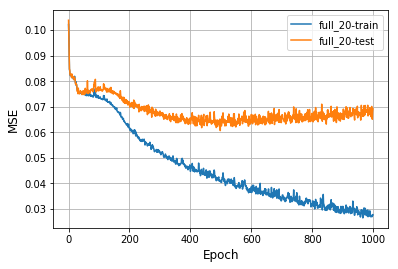

In [75]:
# PLOT net stats.
#plt.plot(pc_stats['train'])
#plt.plot(pc_stats['test'])

# plt.plot(mlp_stats['train'])
# plt.plot(mlp_stats['test'])
# plt.plot(conv_stats['train'])
# plt.plot(conv_stats['test'])

plt.plot(compute_stats_full_20['train'])
plt.plot(compute_stats_full_20['test'])




# plt.plot(compute_stats_full['train'])
# plt.plot(compute_stats_full['test'])

# plt.plot(compute_stats_adj['train'])
# plt.plot(compute_stats_adj['test'])

plt.grid()
plt.legend(['full_20-train', 'full_20-test', 'sparse_20-train', 'sparse_20-test'])
# plt.legend(['PC-Train', 'PC-Test', 'MLP-Train', 'MLP-Test'])
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE', fontsize=12)

plt.savefig('pc_overfitting_vs_cnn.pdf')

# # if use_pc:
# #     title_tag = 'Raw input'
# # else:
# #     title_tag = 'Diff-map input (%s)' % (arch,)

# # plt.title('%s Net-stats for body-variation.'% (title_tag, ))
# # # plt.text(100, 0.3, 'best by val:%.4f' % (val_best,), fontsize=12);

In [59]:
test_params = net_data['test'].labels
test_feed = {net.feed_pl:net_data['test'].feed}
test_pred = net.sess.run(net.net_out, feed_dict=test_feed)

In [60]:
n_test = net_data['test'].n_examples
mu_train = net_data['train'].labels
mu_train = np.repeat(np.mean(mu_train, axis=0), n_test).reshape(12, n_test).T

print average_l2_distance(test_params, mu_train)
print average_l2_distance(test_params, test_pred)

print np.sum(abs(mu_train-test_params)) / test_params.size
print np.sum(abs(test_pred-test_params)) / test_params.size

print average_mse(test_params, mu_train) / test_params.size

0.9776173057104504
1.120135107713072
0.24582937733632898
0.2611188594898562
0.08069150417302243


In [30]:
from general_tools.clustering.plt import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
s = 'test'
l = in_data[s].labels

feed_dict = {feed_pl:in_data[s].feed, labels_pl:l}
p = sess.run([prediction], feed_dict=feed_dict)[0]

conf_m = confusion_matrix(l, p)

NameError: name 'in_data' is not defined

In [31]:
import inspect
inspect.getargspec(plot_confusion_matrix)
plot_confusion_matrix(conf_m, np.unique(in_labels))

NameError: name 'conf_m' is not defined

In [207]:
grid_scaler = np.arange(np.prod(diff_dims)).reshape(diff_dims)
loc_scaled_diffs = []
for d in in_diffs:
    loc_scaled_diffs.append(d + grid_scaler)

In [164]:
def add_location_info_on_diffs(in_diffs, scaler=1.0):
    diff_dims = in_diffs.shape[1:]
    row_pos = np.repeat(np.arange(diff_dims[0]), diff_dims[1]).reshape(diff_dims)
    col_pos = np.repeat(np.arange(diff_dims[1]), diff_dims[0]).reshape(diff_dims[1], diff_dims[0]).T
    row_pos = row_pos.astype(np.float32)
    col_pos = col_pos.astype(np.float32)
    row_pos *= scaler
    col_pos *= scaler

    diffs_with_pos = np.zeros(shape=in_diffs.shape + (3,))
    for i, d in enumerate(in_diffs):
        diffs_with_pos[i, :, :, 0] = d
        diffs_with_pos[i, :, :, 1] = row_pos
        diffs_with_pos[i, :, :, 2] = col_pos
    return diffs_with_pos


In [ ]:
import hdf5storage
lsd_exempler_f = osp.join(top_data_dir, 'lsd_exemplar.mat')
def load_lsd_exemplars(in_file, conf_type='lsd_20'):
    lsd_exemplars = hdf5storage.loadmat(lsd_exempler_f)
    lsd_exemplars = lsd_exemplars[conf_type]
    n_shapes = len(lsd_exemplars)
    map_shape = lsd_exemplars[0][0].shape
    res = np.zeros(shape=(n_shapes, ) + map_shape )
    for i in xrange(n_shapes):
        res[i] = lsd_exemplars[i][0]
    return res
lsd_type = 'lsd_20'
lsd_exemplars = load_lsd_exemplars(lsd_exempler_f, conf_type=lsd_type)
n_cons = lsd_exemplars.shape[-1]